In [1]:
#nearest neighbor rare category detection for multiple classes
#1. import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.markers as mmarkers
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import animation

from mpl_toolkits.mplot3d import axes3d

from numpy.random import rand


import os

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from sklearn.datasets import fetch_openml

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier



from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


from IPython.display import Image
from IPython.display import HTML
from datetime import datetime

In [2]:
#homework framework
#check data path     
data_path = os.path.normpath(os.getcwd() + '/../data/')


mnist_data_file = '/X_and_y_actual.npz'
#mnist_labels_file = 'mnist_full_labels_784.npy'

#objective 1, get Get the provided datasets from D2L. Then for each dataset:
if os.path.exists(data_file := os.path.normpath(data_path + mnist_data_file)):
    X_and_y = np.load(data_file, allow_pickle=True)
    X = X_and_y['arr_0']
    y = X_and_y['arr_1']

#if os.path.exists(os.getcwd() + data_path + mnist_labels_file):
#    y = np.load(os.getcwd() + data_path + mnist_labels_file, allow_pickle=True)

#define report location
report_folder = os.path.normpath(os.getcwd() + '/report/')
report_images = os.path.normpath(report_folder + '/resources/images/')

#check if the folder exists
if not os.path.exists(report_images):
    os.makedirs(report_images)
    
if not os.path.exists(report_images):
    print(f'{report_images} could not be created')
    exit()

print(f'Using {report_images} for report images.')


Using c:\dev\csc730\NNDM\report\resources\images for report images.


Unique labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'bri_0' 'bri_1' 'bri_2' 'bri_3'
 'bri_4' 'bri_5' 'bri_6' 'bri_7' 'bri_8' 'bri_9' 'can_0' 'can_1' 'can_2'
 'can_3' 'can_4' 'can_5' 'can_6' 'can_7' 'can_8' 'can_9' 'dot_0' 'dot_1'
 'dot_2' 'dot_3' 'dot_4' 'dot_5' 'dot_6' 'dot_7' 'dot_8' 'dot_9' 'fog_0'
 'fog_1' 'fog_2' 'fog_3' 'fog_4' 'fog_5' 'fog_6' 'fog_7' 'fog_8' 'fog_9'
 'gla_0' 'gla_1' 'gla_2' 'gla_3' 'gla_4' 'gla_5' 'gla_6' 'gla_7' 'gla_8'
 'gla_9' 'imp_0' 'imp_1' 'imp_2' 'imp_3' 'imp_4' 'imp_5' 'imp_6' 'imp_7'
 'imp_8' 'imp_9' 'mot_0' 'mot_1' 'mot_2' 'mot_3' 'mot_4' 'mot_5' 'mot_6'
 'mot_7' 'mot_8' 'mot_9' 'ori_0' 'ori_1' 'ori_2' 'ori_3' 'ori_4' 'ori_5'
 'ori_6' 'ori_7' 'ori_8' 'ori_9' 'rot_0' 'rot_1' 'rot_2' 'rot_3' 'rot_4'
 'rot_5' 'rot_6' 'rot_7' 'rot_8' 'rot_9' 'sca_0' 'sca_1' 'sca_2' 'sca_3'
 'sca_4' 'sca_5' 'sca_6' 'sca_7' 'sca_8' 'sca_9' 'she_0' 'she_1' 'she_2'
 'she_3' 'she_4' 'she_5' 'she_6' 'she_7' 'she_8' 'she_9' 'sho_0' 'sho_1'
 'sho_2' 'sho_3' 'sho_4' 'sho_5' 'sh

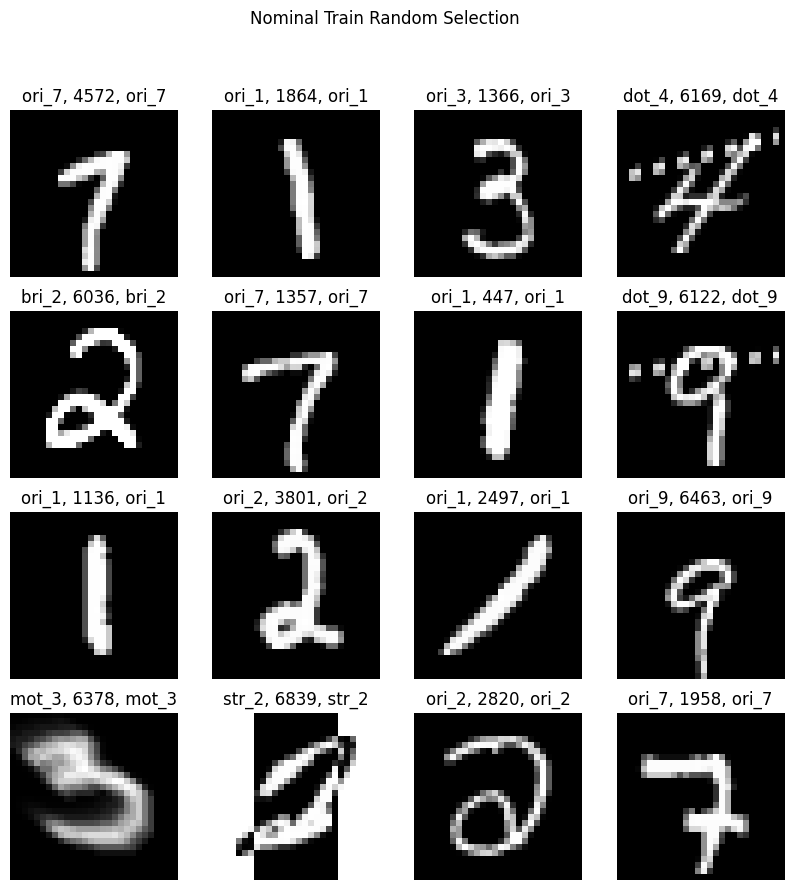

Unique labels: ['bri_0' 'bri_1' 'bri_2' 'bri_3' 'bri_4' 'bri_5' 'bri_6' 'bri_7' 'bri_8'
 'bri_9' 'can_0' 'can_1' 'can_2' 'can_3' 'can_4' 'can_5' 'can_6' 'can_7'
 'can_8' 'can_9' 'dot_0' 'dot_1' 'dot_2' 'dot_3' 'dot_4' 'dot_5' 'dot_6'
 'dot_7' 'dot_8' 'dot_9' 'fog_0' 'fog_1' 'fog_2' 'fog_3' 'fog_4' 'fog_5'
 'fog_6' 'fog_7' 'fog_8' 'fog_9' 'gla_0' 'gla_1' 'gla_2' 'gla_3' 'gla_4'
 'gla_5' 'gla_6' 'gla_7' 'gla_8' 'gla_9' 'imp_0' 'imp_1' 'imp_2' 'imp_3'
 'imp_4' 'imp_5' 'imp_6' 'imp_7' 'imp_8' 'imp_9' 'mot_0' 'mot_1' 'mot_2'
 'mot_3' 'mot_4' 'mot_5' 'mot_6' 'mot_7' 'mot_8' 'mot_9' 'ori_0' 'ori_1'
 'ori_2' 'ori_3' 'ori_4' 'ori_5' 'ori_6' 'ori_7' 'ori_8' 'ori_9' 'rot_0'
 'rot_1' 'rot_2' 'rot_3' 'rot_4' 'rot_5' 'rot_6' 'rot_7' 'rot_8' 'rot_9'
 'sca_0' 'sca_1' 'sca_2' 'sca_3' 'sca_4' 'sca_5' 'sca_6' 'sca_7' 'sca_8'
 'sca_9' 'she_0' 'she_1' 'she_2' 'she_3' 'she_4' 'she_5' 'she_6' 'she_7'
 'she_8' 'she_9' 'sho_0' 'sho_1' 'sho_2' 'sho_3' 'sho_4' 'sho_5' 'sho_6'
 'sho_7' 'sho_8' 'sho_9' 'spa_0' 'sp

In [3]:
#generate example data figures

print(f'Unique labels: {np.unique(y)}')
#fix dataset, if label is length 1 then add 'ori_' as a prefix

y = np.array([f'ori_{yi}' if len(str(yi)) == 1 else yi for yi in y])



fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = np.random.randint(0, X.shape[0])
        ax[i, j].imshow(X[index].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f'{y[index]}, {index}, {y[index]}')
        ax[i, j].axis('off')
plt.suptitle('Nominal Train Random Selection')        
plt.savefig(os.path.normpath(report_images + '/nominal_train_random_selection.png'))
plt.show()

print(f'Unique labels: {np.unique(y)}')



In [4]:
#let's transform the y space
#y_base contains the value labels '0' through '9'
#y_corruption contains the labels of corruption type, if no corruption, label is 'nom'. 
#The rest of the labels are the first three characters of y[]

y_unique = np.unique(y).astype(str)

y_split = np.array([label if np.array(label).shape[0]==2 else ['nom', label[0]] for label in [yi.split('_') for yi in y_unique]])
y_base = y_split[:, 0]
y_corruption =  y_split[:, 1]
y_p = np.array([y_unique, y_split[:,0], y_split[:,1]])
print(f'Unique base labels: {np.unique(y_base)}')
print(f'Unique corruption labels: {np.unique(y_corruption)}')


Unique base labels: ['bri' 'can' 'dot' 'fog' 'gla' 'imp' 'mot' 'ori' 'rot' 'sca' 'she' 'sho'
 'spa' 'str' 'tra' 'zig']
Unique corruption labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


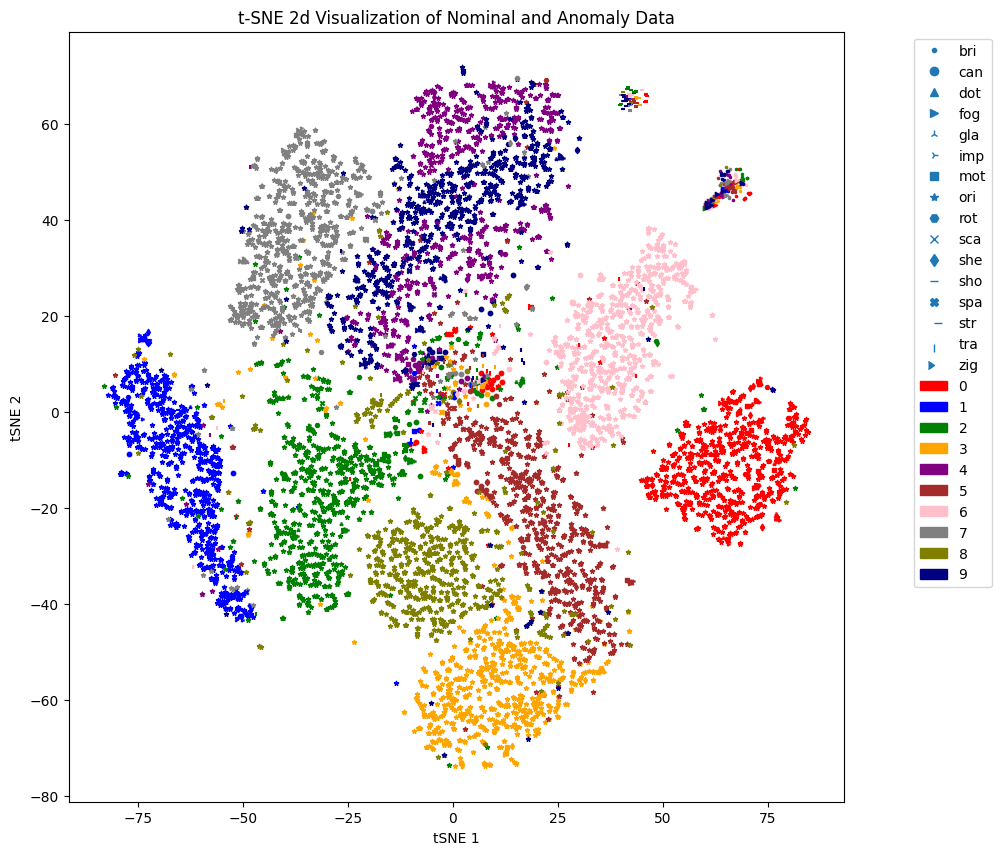

In [5]:
#objective 2 - Visualize the data w/ labels using 2 or 3-D tSNE.

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

#10 line colors
color_list = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'navy']
markers = mmarkers.MarkerStyle.markers
#outline colors number labels

#randomly select len(ist(np.unique(y_p[1]))) colors from color_list

#corruption_color = dict(zip(np.unique(y_p[1]), np.random.choice(color_list, len(np.unique(y_p[1])))))


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for ix, y_label in enumerate(y_p[0]):
    ax.scatter(X_tsne[y == y_label, 0], X_tsne[y == y_label, 1], s=10, marker=list(markers.keys())[2*list(np.unique(y_p[1])).index(y_p[1][ix])], color=color_list[list(np.unique(y_p[0])).index(y_p[0][ix])%len(color_list)])
ax.set_xlabel('tSNE 1')
ax.set_ylabel('tSNE 2')
#generate legend, we want each y_p[1] to have a unique marker and each y_p[0] to have a unique color
#there should be 27 entries in the legend

bottom_right_x = np.max(X_tsne[:, 0])
bottom_right_y = np.min(X_tsne[:, 1])

manual_legend_markers = [mlines.Line2D([bottom_right_y], [bottom_right_x], linestyle='', marker=list(markers.keys())[2*list(np.unique(y_p[1])).index(np.unique(y_p[1])[i])], label=np.unique(y_p[1])[i]) for i in range(len(list(np.unique(y_p[1]))))]
manual_legend_colors = [mpatches.Patch(color=color_list[i%len(color_list)], label=y_p[2][i]) for i in range(len(np.unique(y_p[2])))]
ax.legend(handles=manual_legend_markers + manual_legend_colors, loc='best', bbox_to_anchor=(1.2, 1))

plt.title('t-SNE 2d Visualization of Nominal and Anomaly Data')





#ax.legend()
plt.title('t-SNE 2d Visualization of Nominal and Anomaly Data')
#save the figure with the legend
plt.savefig(os.path.normpath(report_images + '/tsne_2d.png'), bbox_inches='tight', pad_inches=0.25)
plt.show()



In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

class NNDM:
    def __init__(self, priors=None):
        self.priors = priors
        self.m = len(priors)
        self.discovered = [False] * self.m
        self.nn = None
        
    def fit(self, X, y=None):
        n = X.shape[0]
        self.r_primes = []
        
        for i in range(self.m):
            if i == 0:
                continue
            K_i = int(n * self.priors[i])
            nn = NearestNeighbors(n_neighbors=K_i)
            nn.fit(X)
            distances, _ = nn.kneighbors(X)
            self.r_primes.append(np.min(distances[:, -1]))
        
        self.r_primes = [max(self.r_primes)] + self.r_primes
        self.nn = NearestNeighbors(algorithm='brute', metric='euclidean')

        if self.priors == None
            if y == None:
                return None
            else:
                self.priors = self.compute_priors(y)

        self.nn.fit(X)
            
    def select_next(self, X):
        while not all(self.discovered):
            r_prime_index = np.argmin([r for i, r in enumerate(self.r_primes) if not self.discovered[i]])
            r_prime = self.r_primes[r_prime_index]
            
            n_neighbors = [len(self.nn.radius_neighbors(x.reshape(1, -1), radius=r_prime)[0][0]) for x in X]
            
            for t in range(1, X.shape[0]+1):
                scores = []
                for i, x in enumerate(X):
                    if any(np.linalg.norm(x - x_sel) <= self.r_primes[y] for x_sel, y in self.labeled_points):
                        scores.append(-np.inf)
                    else:
                        neighborhood = self.nn.radius_neighbors(x.reshape(1, -1), radius=t*r_prime, return_distance=False)[0]
                        scores.append(n_neighbors[i] - min(n_neighbors[j] for j in neighborhood))
                
                selection_index = np.argmax(scores)
                selection = X[selection_index]
                yield selection, selection_index
                
                label = int(input(f"Enter label for point {selection}: "))
                if not self.discovered[label]:
                    self.discovered[label] = True
                    self.labeled_points.append((selection, label))
                    break
                
    def discover(self, X):            
        self.labeled_points = []
        for selection, index in self.select_next(X):
            print(f"Selected point {selection} at index {index}")
            
    def compute_priors(y):
        classes, counts = np.unique(y, return_counts=True)
        priors = counts / len(y)
        
        # Assuming class 0 is the majority class
        minority_priors = priors[1:] 
        
        return minority_priors       